In [1]:
from IPython.display import display, Math, Latex

def disp(ex):
    display(Math(latex(ex)))

def displ(tex):
    display(Math(tex))

In [2]:
# ZnO   a = 3.25 c = 5.2   Wurtzite (HCP)
# ZnO   4.580    Halite (FCC)

L = 0.458 # nm

l = var("l") # 0.458 # nm
assume(l, "real")
assume(l > 0)

k = var("k") # 10000
assume(k, "real")
assume(k > 0)

alpha = var("alpha") # 5000
assume(alpha, "real")
assume(alpha > 0)

beta = var("beta")   # 5000
assume(beta, "real")
assume(beta > 0)

m = var("m")
M = var("M")
t = var("t")

class Lagrange():

    def __init__(self, rows, cols):
        self.data = []
        self.rows = rows
        self.cols = cols
        self.atom_count = self.rows * self.cols

        self.x = []
        self.y = []
        
        self.X = []
        self.Y = []
        
        self.vx = []
        self.vy = []
        
        self.Vx = []
        self.Vy = []

        for i in range(self.atom_count):

            exec(preparse("self.X_" + str(i) + " = var(\"x_" + str(i) + "\""")"))
            exec(preparse("self.Y_" + str(i) + " = var(\"y_" + str(i) + "\""")"))

            exec(preparse("self.Vx_" + str(i) + " = var(\"vx_" + str(i) + "\""")"))
            exec(preparse("self.Vy_" + str(i) + " = var(\"vy_" + str(i) + "\""")"))

            exec(preparse("self.x_" + str(i) + " = function(\"x_" + str(i) + "\""")(t)"))
            exec(preparse("self.y_" + str(i) + " = function(\"y_" + str(i) + "\""")(t)"))

            exec(preparse("self.vx_" + str(i) + " = function(\"vx_" + str(i) + "\""")(t)"))
            exec(preparse("self.vy_" + str(i) + " = function(\"vy_" + str(i) + "\""")(t)"))

            exec(preparse("self.x += [self.x_" + str(i) + "]"))
            exec(preparse("self.y += [self.y_" + str(i) + "]"))

            exec(preparse("self.X += [self.X_" + str(i) + "]"))
            exec(preparse("self.Y += [self.Y_" + str(i) + "]"))

            exec(preparse("self.vx += [self.vx_" + str(i) + "]"))
            exec(preparse("self.vy += [self.vy_" + str(i) + "]"))

            exec(preparse("self.Vx += [self.Vx_" + str(i) + "]"))
            exec(preparse("self.Vy += [self.Vy_" + str(i) + "]"))

        self.vel = []; # [1.0e+3 m/s]
        self.acc = []; # [1.0e+12 m/s^2]

        self.mass = []; # [kg/mol]

        self.f = [];
        self.w = [];# workaround for bond's potential energy


        self.crd0 = [];
        self.crd  = [];
        self.rc   = [];
        self.nbr  = [];
        self.nbri = [];

        self.step_counter = 0;

        self.sum_of_masses = 0.0; # [kg/mol]

        self.switch_xy = False

        counter = 0

        for row in range(self.rows):
            y0 = (row//4)*3*l
            if (row%4) == 0:
                y = 0 + y0
                x0 = 0
            elif (row%4) == 1:
                y = l/2 + y0
                x0 = l * (1/2*sqrt(3))
            elif (row%4) == 2:
                y = 3*l/2 + y0
                x0 = l * (1/2*sqrt(3))
            elif (row%4) == 3:
                y = 2*l + y0
                x0 = 0

            for col in range(self.cols):
                # self.mass += [65.38 if row%2 == 0 else 15.999]
                # self.mass[counter] *= 1.6605402e-27 * 6.0221367e+23;
                self.mass += [M if row%2 == 0 else m]

                self.sum_of_masses += self.mass[counter];# kg/mol ; all atoms

                x = x0 + col * l * sqrt(3)

                self.rc.append([row, col])
                self.crd.append([self.x[counter], -self.y[counter]])
                self.crd0.append([x, -y])

                #print(row, col, counter, x, y)

                self.vel.append([self.x[counter].diff(t), -self.y[counter].diff(t)]);
                self.acc.append([0.0, 0.0]);

                self.f.append([0.0, 0.0]);
                self.w.append(0.0);

                if (row%4) == 0:
                    nb1 = (row - 1, col)
                    nb2 = (row + 1, col)
                    nb3 = (row + 1, col - 1)
                elif (row%4) == 1:
                    nb1 = (row - 1, col)
                    nb2 = (row - 1, col + 1)
                    nb3 = (row + 1, col)
                elif (row%4) == 2:
                    nb1 = (row - 1, col)
                    nb2 = (row + 1, col)
                    nb3 = (row + 1, col + 1)
                elif (row%4) == 3:
                    nb1 = (row - 1, col - 1)
                    nb2 = (row - 1, col)
                    nb3 = (row + 1, col)

                self.nbr.append([nb1, nb2, nb3])
                self.nbri.append([self.nbr2index(nb1), self.nbr2index(nb2), self.nbr2index(nb3)])

                counter+=1;

    def nbr2index(self, nb):
        r = nb[0]
        c = nb[1]
        return self.rc2index(r, c)

    def rc2index(self, r, c):

        if r < 0: r = self.rows - 1
        if c < 0: c = self.cols - 1
        if r == self.rows: r = 0
        if c == self.cols: c = 0

        index = self.cols * r + c

        return index

    def get_zink_crd(self):
        if self.switch_xy:
            return [[self.crd[self.rc2index(r, c)][1], self.crd[self.rc2index(r, c)][0]] for r in range(self.rows) for c in range(self.cols) if r%2 == 0 ]
        return [self.crd[self.rc2index(r, c)] for r in range(self.rows) for c in range(self.cols) if r%2 == 0 ]

    def get_zink_crd0(self):
        if self.switch_xy:
            return [[self.crd0[self.rc2index(r, c)][1], self.crd0[self.rc2index(r, c)][0]] for r in range(self.rows) for c in range(self.cols) if r%2 == 0 ]
        return [self.crd0[self.rc2index(r, c)] for r in range(self.rows) for c in range(self.cols) if r%2 == 0 ]

    def get_oxigen_crd(self):
        if self.switch_xy:
            return [[self.crd[self.rc2index(r, c)][1], self.crd[self.rc2index(r, c)][0]] for r in range(self.rows) for c in range(self.cols) if r%2 == 1 ]
        return [self.crd[self.rc2index(r, c)] for r in range(self.rows) for c in range(self.cols) if r%2 == 1 ]

    def get_oxigen_crd0(self):
        if self.switch_xy:
            return [[self.crd0[self.rc2index(r, c)][1], self.crd0[self.rc2index(r, c)][0]] for r in range(self.rows) for c in range(self.cols) if r%2 == 1 ]
        return [self.crd0[self.rc2index(r, c)] for r in range(self.rows) for c in range(self.cols) if r%2 == 1 ]

    def box_x(self):
        return self.cols * l * sqrt(3)

    def box_y(self):
        return (self.rows//4) * 3 * l

    def boundary_x(self, crd1, crd2):
        if crd2[0] - crd1[0] > self.box_x() / 2:
            return -1
        if crd2[0] - crd1[0] < - self.box_x() / 2:
            return +1
        return 0

    def boundary_y(self, crd1, crd2):
        if crd2[1] - crd1[1] > self.box_y() / 2:
            return -1
        if crd2[1] - crd1[1] < - self.box_y() / 2:
            return +1
        return 0

    def distance_x(self, crd1, crd2):
        if crd2[0] - crd1[0] > self.box_x() / 2:
            return crd2[0] - crd1[0] - self.box_x()
        if crd2[0] - crd1[0] < - self.box_x() / 2:
            return crd2[0] - crd1[0] + self.box_x()
        return crd2[0] - crd1[0]

    def distance_y(self, crd1, crd2):
        if crd2[1] - crd1[1] > self.box_y() / 2:
            return crd2[1] - crd1[1] - self.box_y()
        if crd2[1] - crd1[1] < - self.box_y() / 2:
            return crd2[1] - crd1[1] + self.box_y()
        return crd2[1] - crd1[1]

    def distance(self, crd1, crd2):
        return sqrt(self.distance_x(crd1, crd2)**2 + self.distance_y(crd1, crd2)**2)

    def distance_x_i(self, i1, i2):
        if self.crd0[i2][0] - self.crd0[i1][0] > self.box_x() / 2:
            return self.crd[i2][0] - self.crd[i1][0] - self.box_x()
        if self.crd0[i2][0] - self.crd0[i1][0] < - self.box_x() / 2:
            return self.crd[i2][0] - self.crd[i1][0] + self.box_x()
        return self.crd[i2][0] - self.crd[i1][0]

    def distance_y_i(self, i1, i2):
        if self.crd0[i2][1] - self.crd0[i1][1] > self.box_y() / 2:
            return self.crd[i2][1] - self.crd[i1][1] - self.box_y()
        if self.crd0[i2][1] - self.crd0[i1][1] < - self.box_y() / 2:
            return self.crd[i2][1] - self.crd[i1][1] + self.box_y()
        return self.crd[i2][1] - self.crd[i1][1]
    
    def distance_i(self, i1, i2):
        return sqrt(self.distance_x_i(i1, i2)**2 + self.distance_y_i(i1, i2)**2)

    def calc_atom(self, i):
        fx = 0.0
        fy = 0.0
        w = 0.0

        fy_left_boundary = 0.0
        wy_left_boundary = 0.0
        fy_right_boundary = 0.0
        wy_right_boundary = 0.0

        for nbr in self.nbri[i]:

            d  = self.distance_i  (i, nbr)
            dx = self.distance_x_i(i, nbr)
            dy = self.distance_y_i(i, nbr)
            
            bx = self.boundary_x(self.crd[i], self.crd[nbr])
            by = self.boundary_y(self.crd[i], self.crd[nbr])
            
            cx = dx/d
            cy = dy/d

            dl = d - l

            f = k * dl # + alpha * dl**2 + beta * dl**3

            # bond's potential energy
            dw = k * dl * dl / 2 # + alpha * dl**3 / 3 + beta * dl**4 / 4

            fx += f * cx
            fy += f * cy
            w  += dw

            if by > 0:
                fy_left_boundary += fy
                wy_left_boundary += dw/2
            if by < 0:
                fy_right_boundary += fy
                wy_right_boundary += dw/2

        self.f[i][0] = fx
        self.f[i][1] = fy
        self.w[i]    = w/2 # assign to atom half of bond's potential energy

    def ComputeForce(self):
        for n1 in range(self.atom_count):
            self.calc_atom(n1)

    def KineticEnergy(self):
        energy = 0.0

        for n1 in range(self.atom_count):
            tmpX = self.mass[n1]/2

            for n2 in [0,1]:
                tmp1 = self.vel[n1][n2];
                tmp2 = tmpX * tmp1 * tmp1;

                energy += tmp2;

        return energy;

    def PotentialEnergy(self):
        counter = 0
        energy = 0.0
        for row in range(self.rows):
            for col in range(self.cols):
                tmpW = self.w[counter]
                energy += tmpW;
                counter+=1;

        return energy
    
    def Lagrangian(self):
        return self.KineticEnergy() - self.PotentialEnergy()
    
    def momentum(self):
        L = self.Lagrangian()

        px = []
        py = []

        for i in range(self.atom_count):
            px += [L.subs(self.x[i].diff(t) == self.Vx[i]).diff(self.Vx[i]).subs(self.Vx[i] == self.x[i].diff(t))]
            py += [L.subs(self.y[i].diff(t) == self.Vy[i]).diff(self.Vy[i]).subs(self.Vy[i] == self.y[i].diff(t))]
    
        return(px, py)
    
    def Momentum(self):
        L = self.Lagrangian()

        Px = []
        Py = []

        for i in range(self.atom_count):
            Px += [L.subs(self.x[i].diff(t) == self.Vx[i]).diff(self.Vx[i]).subs(self.Vx[i] == self.vx[i])]
            Py += [L.subs(self.y[i].diff(t) == self.Vy[i]).diff(self.Vy[i]).subs(self.Vy[i] == self.vy[i])]

        return(Px, Py)
    
    def EulerLagrange(self):
        L = self.Lagrangian()
        px, py = m1.momentum()

        # система уравнений Эйлера-Лагранжа
        eqs_x = []
        eqs_y = []

        for i in range(self.atom_count):
            eqs_x += [px[i].diff(t) - L.subs(self.x[i] == self.X[i]).diff(self.X[i]).subs(self.X[i] == self.x[i]) == 0]
            eqs_y += [py[i].diff(t) - L.subs(self.y[i] == self.Y[i]).diff(self.Y[i]).subs(self.Y[i] == self.y[i]) == 0]

        return eqs_x, eqs_y
    
    def EulerLagrangeSolution(self):
        eqs_x, eqs_y = self.EulerLagrange()
        
        Ax = []
        Ay = []
        lambda_x = []
        lambda_y = []

        for i in range(self.atom_count):
            exec(preparse("Ax_"     + str(i) + " = var(\"A_x_"     + str(i) + "\""")"))
            exec(preparse("Ay_"     + str(i) + " = var(\"A_y_"     + str(i) + "\""")"))
            exec(preparse("lambdax_"   + str(i) + " = var(\"lambda_x_"   + str(i) + "\""")"))
            exec(preparse("lambday_"   + str(i) + " = var(\"lambda_y_"   + str(i) + "\""")"))
            exec(preparse("Ax       += [A_x_"     + str(i) + "]"))
            exec(preparse("Ay       += [A_y_"     + str(i) + "]"))
            exec(preparse("lambda_x += [lambdax_"   + str(i) + "]"))
            exec(preparse("lambda_y += [lambday_"   + str(i) + "]"))

        # решение системы уравнений Эйлера-Лагранжа
        # ищем в виде
        xi = []
        yi = []
        #kkk = 1
        for i in range(self.atom_count):
            #xi += [A[i]*cos(omega[i]*t + phi[i])]
            xi += [Ax[i]*exp(lambda_x[i]*t)]
            yi += [Ay[i]*exp(lambda_y[i]*t)]
            #kkk *= exp(lambdas[i]*t)
            #disp(xi[i])
            #disp(yi[i])
        #disp(kkk)

        # подставляя решения в систему
        # уравнений Эйлера Лагранжа
        # получаем систему линейных алгебраичных уравнений
        eqsi_x = []
        eqsi_y = []
        for i in range(self.atom_count):
            eqx_i = eqs_x[i].substitute_function(self.x[i] == xi[i])
            eqy_i = eqs_y[i].substitute_function(self.y[i] == yi[i])
            for j in range(self.atom_count):
                eqx_i = eqx_i.subs(self.x[j] == xi[j])
                eqx_i = eqx_i.subs(self.y[j] == yi[j])
                
                eqy_i = eqy_i.subs(self.x[j] == xi[j])
                eqy_i = eqy_i.subs(self.y[j] == yi[j])

            eqsi_x += [ eqx_i ]
            eqsi_y += [ eqy_i ]
            disp(eqsi_x[i])
            disp(eqsi_y[i])

    def plot(self):
        from sage.plot.plot import Graphics
        from sage.plot.point import point

        p = Graphics()
        p += point([[x.subs(l==L), y.subs(l==L)] for x,y in self.get_zink_crd0()],   marker='o', markeredgecolor='blue', size=20)
        p += point([[x.subs(l==L), y.subs(l==L)] for x,y in self.get_oxigen_crd0()], marker='o', markeredgecolor='red',  size=2)
        
        if self.switch_xy:
            p += line([(self.ymax().subs(l==L), self.xmax().subs(l==L)),
                       (self.ymax().subs(l==L), self.xmin().subs(l==L))])
            
            p += line([(self.ymax().subs(l==L), self.xmax().subs(l==L)),
                       (self.ymin().subs(l==L), self.xmax().subs(l==L))])
            
            p += line([(self.ymin().subs(l==L), self.xmax().subs(l==L)),
                       (self.ymin().subs(l==L), self.xmin().subs(l==L))])
            
            p += line([(self.ymin().subs(l==L), self.xmin().subs(l==L)),
                       (self.ymax().subs(l==L), self.xmin().subs(l==L))])
        else:
            p += line([(self.xmax().subs(l==L), self.ymax().subs(l==L)),
                       (self.xmax().subs(l==L), self.ymin().subs(l==L))])
            
            p += line([(self.xmax().subs(l==L), self.ymax().subs(l==L)),
                       (self.xmin().subs(l==L), self.ymax().subs(l==L))])
            
            p += line([(self.xmin().subs(l==L), self.ymax().subs(l==L)),
                       (self.xmin().subs(l==L), self.ymin().subs(l==L))])
            
            p += line([(self.xmin().subs(l==L), self.ymin().subs(l==L)),
                       (self.xmax().subs(l==L), self.ymin().subs(l==L))])

        return p

    def xmin(self):
        return -l/2 * (1/2*sqrt(3))
    def xmax(self):
        return -l/2 * (1/2*sqrt(3)) + self.box_x()

    def ymax(self):
        return +l/2
    def ymin(self):
        return l/2 - self.box_y()

    def show(self, p):
        if self.switch_xy:
            p.show(aspect_ratio=1, axes=False,
                             ymax = self.xmax().subs(l==L), ymin = self.xmin().subs(l==L),
                             xmin = self.ymin().subs(l==L), xmax = self.ymax().subs(l==L)
                            )
        else:
            p.show(aspect_ratio=1, axes=False,
                             ymax = self.ymax().subs(l==L), ymin = self.ymin().subs(l==L),
                             xmin = self.xmin().subs(l==L), xmax = self.xmax().subs(l==L)
                            )

In [3]:
rw = 2
cl = 2

# here I create two models
m1 = Lagrange(rw * 2, cl)
m2 = Lagrange(rw * 2, cl)

In [4]:
m1.get_zink_crd()

[[x_0(t), -y_0(t)], [x_1(t), -y_1(t)], [x_4(t), -y_4(t)], [x_5(t), -y_5(t)]]

In [5]:
m1.get_oxigen_crd()

[[x_2(t), -y_2(t)], [x_3(t), -y_3(t)], [x_6(t), -y_6(t)], [x_7(t), -y_7(t)]]

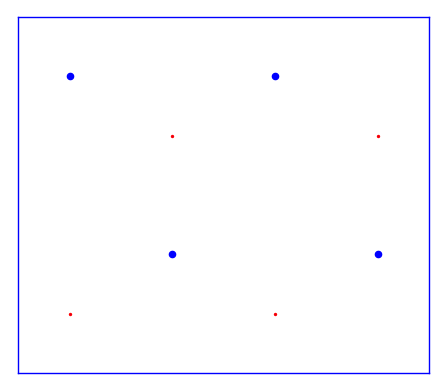

In [6]:
p = m1.plot()
m1.show(p)

In [7]:
m1.ComputeForce()
disp(m1.PotentialEnergy())

<IPython.core.display.Math object>

In [8]:
disp(m1.KineticEnergy())

<IPython.core.display.Math object>

In [9]:
disp(m1.Lagrangian())

<IPython.core.display.Math object>

In [10]:
Px, Py = m1.Momentum()
disp(Px)
disp(Py)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [11]:
px, py = m1.momentum()
disp(px)
disp(py)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [12]:
eqs_x, eqs_y = m1.EulerLagrange()

In [13]:
for eq_x in eqs_x:
    disp(eq_x)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [14]:
for eq_y in eqs_y:
    disp(eq_y)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [15]:
len(eqs_x)

8

In [16]:
m1.EulerLagrangeSolution()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>